## 6.2 The PyTorch nn module


The reason we want to do this batching is multifaceted. One big motivation is to make
sure the computation we’re asking for is big enough to saturate the computing
resources we’re using to perform the computation. GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle

In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

We reshape our B
inputs to B × Nin, where Nin is 1. That is easily done with unsqueeze:

In [3]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) #Adds the extra dimension at axis 1
t_u = torch.tensor(t_u).unsqueeze(1)
t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([0, 3, 8, 5, 7, 2, 1, 4, 9]), tensor([10,  6]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [6]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-0.5389],
        [-0.5509]], grad_fn=<AddmmBackward0>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.0035]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([-0.5627], requires_grad=True)

In [9]:
x = torch.ones(1)
linear_model(x)

tensor([-0.5592], grad_fn=<ViewBackward0>)

In [10]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.5592],
        [-0.5592],
        [-0.5592],
        [-0.5592],
        [-0.5592],
        [-0.5592],
        [-0.5592],
        [-0.5592],
        [-0.5592],
        [-0.5592]], grad_fn=<AddmmBackward0>)

In [11]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

It hasn’t changed practically at all, except that now we don’t pass params explicitly to
model since the model itself holds its Parameters internally.

In [12]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

: the loss. Indeed, nn comes
with several common loss functions, among them nn.MSELoss (MSE stands for Mean
Square Error)<br>Loss functions
in nn are still subclasses of nn.Module, so we will create an instance and call it as a
function.

In [13]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),#We are no longer using our handwritten loss function from earlier.
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 98.3742, Validation loss 128.9716
Epoch 1000, Training loss 3.6596, Validation loss 4.2321
Epoch 2000, Training loss 2.6668, Validation loss 4.8553
Epoch 3000, Training loss 2.6293, Validation loss 5.1649

Parameter containing:
tensor([[5.3975]], requires_grad=True)
Parameter containing:
tensor([-17.8595], requires_grad=True)


Everything else input into our training loop stays the same. Even our results remain
the same as before. Of course, getting the same results is expected, as a difference
would imply a bug in one of the two implementations.

In [14]:
#We chose 13 arbitrarily. We wanted a number that was a different size from the other tensor shapes we have floating around.
seq_model = nn.Sequential(
nn.Linear(1, 13),
nn.Tanh(),
nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

e. The model fans out from
1 input feature to 13 hidden features, passes them through a tanh activation, and linearly combines the resulting 13 numbers into 1 output feature.

### 6.3.2 Inspecting the parameters


In [15]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

Again, after we call model.backward(),
all parameters are populated with their grad, and the optimizer then updates their values accordingly during the optimizer.step() call.

s. When inspecting parameters of a model
made up of several submodules, it is handy to be able to identify parameters by name.
There’s a method for that, called named_parameters:

In [16]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [17]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
('hidden_linear', nn.Linear(1, 8)),
('hidden_activation', nn.Tanh()),
('output_linear', nn.Linear(8, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


#### We can also access a particular Parameter by using submodules as attributes:

This is useful for inspecting parameters or their gradients: for instance, to monitor
gradients during training, as we did at the beginning of this chapter. Say we want to
print out the gradients of weight of the linear portion of the hidden layer. We can run
the training loop for the new neural network model and then look at the resulting
gradients after the last epoch:

In [19]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 169.6061, Validation loss 213.9051
Epoch 1000, Training loss 5.2332, Validation loss 7.8175
Epoch 2000, Training loss 3.8707, Validation loss 3.2744
Epoch 3000, Training loss 2.1833, Validation loss 3.7960
Epoch 4000, Training loss 1.7382, Validation loss 3.9852
Epoch 5000, Training loss 1.6434, Validation loss 4.0823
output tensor([[ 2.0609e+01],
        [-2.2256e-03]], grad_fn=<AddmmBackward0>)
answer tensor([[21.],
        [ 3.]])
hidden tensor([[ 6.9184e+00],
        [ 2.5883e-01],
        [-6.1857e+00],
        [ 3.6975e+00],
        [ 5.3804e-04],
        [ 6.8142e+00],
        [-4.8198e+00],
        [ 1.8148e-01]])


### 6.3.3 Comparing to the linear model AND PLOTTING

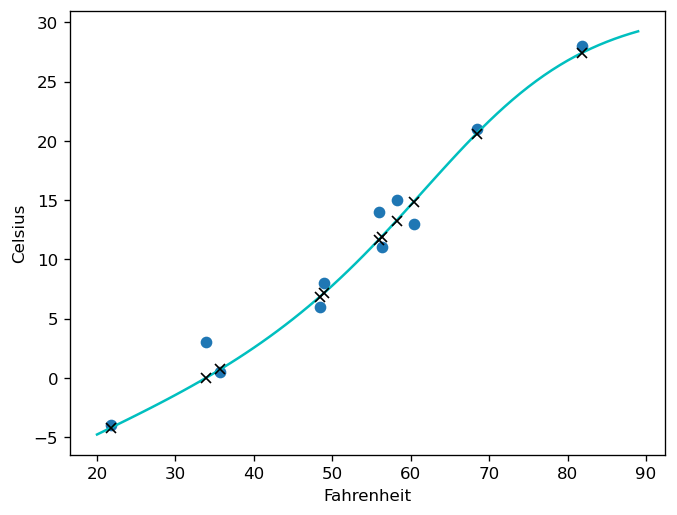

In [20]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=120)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')